<a href="https://colab.research.google.com/github/Hadjadj-Benakmoum/MobilityPredictionUsingML/blob/main/LSTM(RNN)_next_lecation_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout,LSTM, CuDNNLSTM
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import numpy as np
import time

ImportError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFcCC5vJOcox0gZWan7_8SvBT7E7WEJvJoIsEhNi3fwjQ132qIqk3M
Mounted at /content/drive


# Script paramters


In [ ]:
#You have to change this path to your mobility file 
path = '/content/drive/My Drive/FinalProject/data/10.mv'

window = 8
train_rate = 0.5

embedding=True
embedding_size= 10
hidden_lstm=True
lstm_nb_units = 30
hidden_dense=True
dense_nb_unit = 50

batch_size = 256
nb_epochs = 10



# Read data from mobility file


In [ ]:
def read_location_file(path):
  fichier = open(path, 'r')
  lines = fichier.readlines()
  fichier.close()
  locations_seq = [line.split()[1] for line in lines]
  return locations_seq

locations_seq = read_location_file(path)
print('The length of the sequence :',len(locations_seq))       
print (locations_seq[0:5]) 

The length of the sequence : 2156
['LibBldg3AP6', 'LibBldg3AP2', 'LibBldg3AP6', 'LibBldg3AP1', 'LibBldg3AP2']


# Preprocessing of data (Encode lcoation and prepare thel for the model)


In [ ]:
from keras.preprocessing.text import Tokenizer
# Encode locations as integer sequence
def locations_to_integers(locations_seq):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(locations_seq)
  encoded_seq = tokenizer.texts_to_sequences(locations_seq)
  # Convert a list of lists to a flat list 
  encoded_seq  = [val for sublist in encoded_seq for val in sublist]
  return encoded_seq,tokenizer
encoded_seq,tokenizer =locations_to_integers(locations_seq)
 
# Display the vocabulary details
vocabulary_size = len(tokenizer.word_counts)+1
print('Vocabulary Size:', vocabulary_size)
print('Mapping between locations and integers:')
print(tokenizer.word_index)
print('Encoded sequence :')
print (encoded_seq[0:10])


Vocabulary Size: 8
Mapping between locations and integers:
{'libbldg3ap2': 1, 'libbldg3ap7': 2, 'libbldg3ap6': 3, 'off': 4, 'libbldg3ap5': 5, 'libbldg3ap3': 6, 'libbldg3ap1': 7}
Encoded sequence :
[3, 1, 3, 7, 1, 3, 5, 4, 5, 3]


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
def build_X_Y(encoded_seq,window=window):
  temp_seqs = np.zeros((len(encoded_seq),window+1), dtype='int32')
  for i in range(len(encoded_seq)-window):
    temp_seqs[i] = encoded_seq[i:(i+window+1)]
  X = temp_seqs[:,:-1]
  y = temp_seqs[:,-1]
  return X,y

X,y = build_X_Y(encoded_seq,window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_rate, shuffle = False)

print(X_train[:5])
print(y_train[:5])
print(X_test[:5])
print(y_test[:5])

[[3 1 3 7 1 3 5 4]
 [1 3 7 1 3 5 4 5]
 [3 7 1 3 5 4 5 3]
 [7 1 3 5 4 5 3 5]
 [1 3 5 4 5 3 5 3]]
[5 3 5 3 6]
[[1 2 1 2 1 2 1 2]
 [2 1 2 1 2 1 2 1]
 [1 2 1 2 1 2 1 2]
 [2 1 2 1 2 1 2 1]
 [1 2 1 2 1 2 1 2]]
[1 2 1 2 1]


In [ ]:
from keras.utils import to_categorical
def integer_to_vector(X_train, X_test, y_train, y_test,Embedding=embedding):
  if(not Embedding):
    X_train = to_categorical(X_train,num_classes=vocabulary_size)
    X_test = to_categorical(X_test,num_classes=vocabulary_size)
  y_train = to_categorical(y_train,num_classes=vocabulary_size)
  y_test = to_categorical(y_test,num_classes=vocabulary_size)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = integer_to_vector(X_train, X_test, y_train, y_test,embedding)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1078, 8)
(1078, 8)
(1078, 8)
(1078, 8)


# Build the graph of the RNN Model


In [ ]:
from keras.layers import Dense, Embedding, Dropout,LSTM
from keras.models import Sequential
def build_model(vocabulary_size=vocabulary_size,
                window = window,
                embedding = embedding,
                embedding_size = embedding_size,
                hidden_lstm = hidden_lstm,
                lstm_nb_units = lstm_nb_units,
                dense_nb_unit = dense_nb_unit,
                hidden_dense = hidden_dense):
  
  time_step = window

  model = Sequential()
  if(embedding):
    model.add(Embedding(vocabulary_size, embedding_size, input_length=time_step))
    model.add(LSTM(lstm_nb_units,activation='relu',return_sequences=True))
  else:
    model.add(LSTM(lstm_nb_units,activation='relu',input_shape=(time_step,vocabulary_size),return_sequences=True))

  if(hidden_lstm):
    model.add(LSTM(lstm_nb_units,activation='relu'))
    
  if(hidden_dense):
    model.add(Dense(20,activation='relu'))

  model.add(Dense(vocabulary_size, activation='softmax'))

  # compiling the network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = build_model()

# Visualize the RNN model details


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 10)             80        
_________________________________________________________________
lstm (LSTM)                  (None, 8, 30)             4920      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
Total params: 13,108
Trainable params: 13,108
Non-trainable params: 0
_________________________________________________________________
None


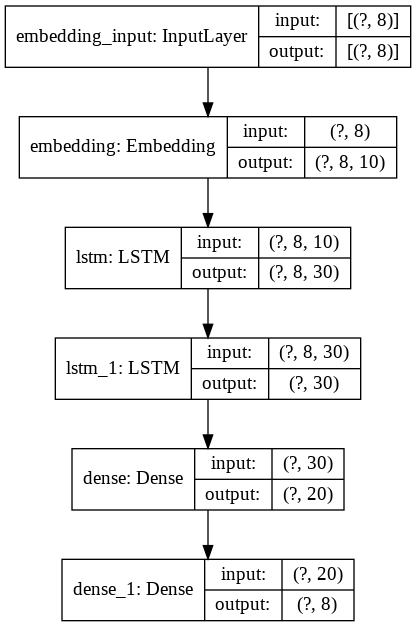

In [ ]:
from keras.utils.vis_utils import plot_model
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train the model using the preprocessed training data (model.fit)


In [ ]:
model.fit(X_train,y_train,batch_size=batch_size, epochs=nb_epochs,validation_data=(X_test,y_test ))

Epoch 1/10
5/5 [==============================] - 1s 103ms/step - loss: 2.0741 - accuracy: 0.3813 - val_loss: 2.0662 - val_accuracy: 0.3098
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 2.0550 - accuracy: 0.4555 - val_loss: 2.0507 - val_accuracy: 0.3098
Epoch 3/10
5/5 [==============================] - 0s 21ms/step - loss: 2.0319 - accuracy: 0.4555 - val_loss: 2.0318 - val_accuracy: 0.3098
Epoch 4/10
5/5 [==============================] - 0s 21ms/step - loss: 2.0033 - accuracy: 0.4555 - val_loss: 2.0078 - val_accuracy: 0.3098
Epoch 5/10
5/5 [==============================] - 0s 21ms/step - loss: 1.9659 - accuracy: 0.4555 - val_loss: 1.9754 - val_accuracy: 0.3098
Epoch 6/10
5/5 [==============================] - 0s 21ms/step - loss: 1.9140 - accuracy: 0.4555 - val_loss: 1.9292 - val_accuracy: 0.3098
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 1.8370 - accuracy: 0.4555 - val_loss: 1.8587 - val_accuracy: 0.3098
Epoch 8/10
5/5 [==========

```
# Ce texte est au format code
```

# Test the model using the prprocessed testing data (model.evaluate)


In [ ]:
result = model.evaluate(X_test,y_test)
print('Accuracy : ',result[1])

34/34 [==============================] - 0s 3ms/step - loss: 1.4942 - accuracy: 0.3098
Accuracy :  0.30983301997184753


# Test the model with one location


Context of the size (window) ---> Encoded context ---> RNN model ---> RNN output vector ---> Next location

In [ ]:
#This function converts the input to the format understood by the RNN model.
#Context of the size (window) ---> Encoded context

def encode_sequence(context,Tokenizer=Tokenizer,Embedding=embedding):
  encoded_seq = tokenizer.texts_to_sequences(context)
  # Convert a list of lists to a flat list 
  encoded_seq  = [val for sublist in encoded_seq for val in sublist]
  encoded_seq  = np.array(encoded_seq)
  if not Embedding:
    encoded_seq  = to_categorical(encoded_seq,num_classes=vocabulary_size)
    result  = encoded_seq.reshape(1,encoded_seq.shape[0],encoded_seq.shape[1])
  else:
    result = np.zeros((1,len(encoded_seq)))
    result[0] = encoded_seq
  
  return result

#This function converts the output vector of the RNN to the string of next location
#RNN output vector ---> Next location
def decode_RNN_output(model_output,Tokenizer=Tokenizer):
  index_next_location = np.argmax(model_output)+1
  next_location = tokenizer.sequences_to_texts([[index_next_location]])[0]
  return next_location

In [ ]:
#Just an example with the first window of locations
context = locations_seq[:window]
real_next_location = locations_seq[window].lower()

#Context of the size (window) ---> Encoded context 
encoded_context = encode_sequence(context)

#Encoded context ---> RNN model ---> RNN output vector
model_output = model.predict(encoded_context)

#RNN output vector ---> Next location
next_location = decode_RNN_output(model_output)

#Result for this example 
print('Correct next location : ',real_next_location)
print('Pridicted next location : ',next_location)

Correct next location :  libbldg3ap5
Pridicted next location :  libbldg3ap6
